In [ ]:
#convlstm多变量多步 加入SED
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X14 = dataset[:,0]
X14_scaler= (X14-numpy.min(X14))/(numpy.max(X14)-numpy.min(X14))
X14_scaler = X14_scaler.reshape(-1)
X23 = dataset[:,6]#Y
X23_scaler= (X23-numpy.min(X23))/(numpy.max(X23)-numpy.min(X23))
X23_scaler = X23_scaler.reshape(-1)
X24 = dataset[:,1]
X24_scaler= (X24-numpy.min(X24))/(numpy.max(X24)-numpy.min(X24))
X24_scaler = X24_scaler.reshape(-1)
X31 = dataset[:,2]
X31_scaler= (X31-numpy.min(X31))/(numpy.max(X31)-numpy.min(X31))
X31_scaler = X31_scaler.reshape(-1)
X42 = dataset[:,4]
X42_scaler= (X42-numpy.min(X42))/(numpy.max(X42)-numpy.min(X42))
X42_scaler = X42_scaler.reshape(-1)
X44 = dataset[:,3]
X44_scaler= (X44-numpy.min(X44))/(numpy.max(X44)-numpy.min(X44))
X44_scaler = X44_scaler.reshape(-1)
X46 = dataset[:,5]
X46_scaler= (X46-numpy.min(X46))/(numpy.max(X46)-numpy.min(X46))
X46_scaler = X46_scaler.reshape(-1)
#print(X14_scaler,X23_scaler,X24_scaler,X31_scaler,X42_scaler,X44_scaler,X46_scaler)

XX = numpy.zeros([324,4,6])
XX[:,0,3] = X14_scaler
XX[:,1,2] = X23_scaler
XX[:,1,3] = X24_scaler
XX[:,2,0] = X31_scaler
XX[:,3,1] = X42_scaler
XX[:,3,3] = X44_scaler
XX[:,3,5] = X46_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(testY),1,2]
print("转为监督学习，训练集数据长度：", len(trainX))
print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,4,6, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 4,6, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(timestep, 4,6,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=50)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)

    # 逆缩放预测值
    #dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', engine='python')
    #dataset = dataframe.values
    #dataset = dataset.astype('float32')
    #Y = dataset[:,6]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_re = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_re=trainY_re.reshape((246,1))
    testPredict = testPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #testY_re = testY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    testY_ori=X23[train_size+timestep:len(dataset)]
    testY_ori=testY_ori.reshape((66,1))

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []
    error1= []
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
    squaredError = []
    absError = []
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
    MSE=sum(squaredError) / len(squaredError)
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 6, 2, 3, 1) (66, 6, 2, 3, 1)
Train on 246 samples
Epoch 1/700
246/246 [==============================] - 7s 30ms/sample - loss: 0.0497
Epoch 2/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0459
Epoch 3/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0412
Epoch 4/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0387
Epoch 5/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0369
Epoch 6/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0353
Epoch 7/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0340
Epoch 8/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0324
Epoch 9/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0315
Epoch 10/700
246/246 [==============================] - 0s 1ms/sample - loss: 0

246/246 [==============================] - 0s 1ms/sample - loss: 0.0035
Epoch 95/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0035
Epoch 96/700
246/246 [==============================] - 0s 956us/sample - loss: 0.0039
Epoch 97/700
246/246 [==============================] - 0s 962us/sample - loss: 0.0037
Epoch 98/700
246/246 [==============================] - 0s 922us/sample - loss: 0.0036
Epoch 99/700
246/246 [==============================] - 0s 959us/sample - loss: 0.0044
Epoch 100/700
246/246 [==============================] - 0s 977us/sample - loss: 0.0038
Epoch 101/700
246/246 [==============================] - 0s 965us/sample - loss: 0.0036
Epoch 102/700
246/246 [==============================] - 0s 965us/sample - loss: 0.0040
Epoch 103/700
246/246 [==============================] - 0s 959us/sample - loss: 0.0041
Epoch 104/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0036
Epoch 105/700
246/246 [==============================] - 

246/246 [==============================] - 0s 1ms/sample - loss: 0.0031
Epoch 189/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0031
Epoch 190/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0030
Epoch 191/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0030
Epoch 192/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0031
Epoch 193/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0033
Epoch 194/700
246/246 [==============================] - 0s 998us/sample - loss: 0.0032
Epoch 195/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0032
Epoch 196/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0035
Epoch 197/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0033
Epoch 198/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0035
Epoch 199/700
246/246 [==============================] - 0s 1ms/sa

246/246 [==============================] - 0s 1ms/sample - loss: 0.0028
Epoch 284/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0028
Epoch 285/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0029
Epoch 286/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0028
Epoch 287/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0028
Epoch 288/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0029
Epoch 289/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 290/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0030
Epoch 291/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0030
Epoch 292/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0029
Epoch 293/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0029
Epoch 294/700
246/246 [==============================] - 0s 1ms/samp

246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 379/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0026
Epoch 380/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0025
Epoch 381/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 382/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0026
Epoch 383/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 384/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 385/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0025
Epoch 386/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0025
Epoch 387/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0025
Epoch 388/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0026
Epoch 389/700
246/246 [==============================] - 0s 1ms/samp

246/246 [==============================] - 0s 1ms/sample - loss: 0.0024
Epoch 474/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0024
Epoch 475/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0024
Epoch 476/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0023
Epoch 477/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0025
Epoch 478/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0026
Epoch 479/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 480/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 481/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 482/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 483/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 484/700
246/246 [==============================] - 0s 1ms/samp

246/246 [==============================] - 0s 1ms/sample - loss: 0.0019
Epoch 569/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 570/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0021
Epoch 571/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0021
Epoch 572/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 573/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 574/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0020
Epoch 575/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0019
Epoch 576/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0019
Epoch 577/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0017
Epoch 578/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 579/700
246/246 [==============================] - 0s 1ms/samp

246/246 [==============================] - 0s 1ms/sample - loss: 0.0015
Epoch 664/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0015
Epoch 665/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0015
Epoch 666/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0014
Epoch 667/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0016
Epoch 668/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0015
Epoch 669/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0016
Epoch 670/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0016
Epoch 671/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0016
Epoch 672/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0015
Epoch 673/700
246/246 [==============================] - 0s 1ms/sample - loss: 0.0016
Epoch 674/700
246/246 [==============================] - 0s 1ms/samp

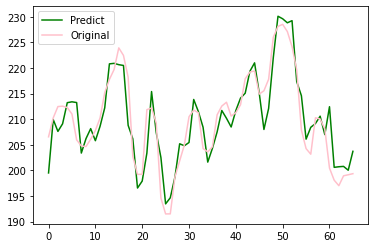

Running time: 204 seconds


In [19]:
#convlstm多变量多步 加入SED
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X11 = dataset[:,0]#Y
X11_scaler= (X11-numpy.min(X11))/(numpy.max(X11)-numpy.min(X11))
X11_scaler = X11_scaler.reshape(-1)

X12 = dataset[:,1]
X12_scaler= (X12-numpy.min(X12))/(numpy.max(X12)-numpy.min(X12))
X12_scaler = X12_scaler.reshape(-1)

X13 = dataset[:,2]
X13_scaler= (X13-numpy.min(X13))/(numpy.max(X13)-numpy.min(X13))
X13_scaler = X13_scaler.reshape(-1)

X21 = dataset[:,3]
X21_scaler= (X21-numpy.min(X21))/(numpy.max(X21)-numpy.min(X21))
X21_scaler = X21_scaler.reshape(-1)

X22 = dataset[:,4]
X22_scaler= (X22-numpy.min(X22))/(numpy.max(X22)-numpy.min(X22))
X22_scaler = X22_scaler.reshape(-1)

X23 = dataset[:,5]
X23_scaler= (X23-numpy.min(X23))/(numpy.max(X23)-numpy.min(X23))
X23_scaler = X23_scaler.reshape(-1)



XX = numpy.zeros([324,2,3])
XX[:,0,0] = X11_scaler
XX[:,0,1] = X12_scaler
XX[:,0,2] = X13_scaler
XX[:,1,0] = X21_scaler
XX[:,1,1] = X22_scaler
XX[:,1,2] = X23_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,2,3, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 2,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=72, kernel_size=(1, 2), activation='relu', input_shape=(timestep, 2,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 2),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=700)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    testPre1 = testPredict[:,0,0,:]
    testPre1 = testPre1.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    testBDX_re = testPre1*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    testBDX_re = testBDX_re.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    testPre_re=QSX + testBDX_re
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre_re[i])
        error1.append(abs((testY_ori[i] - testPre_re[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre_re[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre_re[i]*testPre_re[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=numpy.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre_re[i])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre_re=testPre_re.reshape(-1)
    testPre_re=pandas.DataFrame(testPre_re)
    testPre_re.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre_re,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre_re)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 6, 3, 3, 1) (66, 6, 3, 3, 1)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 9s 37ms/sample - loss: 0.0488
Epoch 2/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0467
Epoch 3/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 4/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 5/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 6/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 7/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0367
Epoch 8/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 9/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 10/1000
246/246 [==============================] - 0s 2ms/sample

246/246 [==============================] - 0s 2ms/sample - loss: 0.0049
Epoch 95/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0046
Epoch 96/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0046
Epoch 97/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0048
Epoch 98/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0057 0s - loss: 
Epoch 99/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0051
Epoch 100/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0046
Epoch 101/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0045
Epoch 102/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0047
Epoch 103/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0049
Epoch 104/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0045
Epoch 105/1000
246/246 [===========================

246/246 [==============================] - 0s 2ms/sample - loss: 0.0036
Epoch 189/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0037
Epoch 190/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0036
Epoch 191/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0035
Epoch 192/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0034
Epoch 193/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0034
Epoch 194/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0035
Epoch 195/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0033
Epoch 196/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0033
Epoch 197/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0033
Epoch 198/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0034
Epoch 199/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0029
Epoch 283/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0028
Epoch 284/1000
246/246 [==============================] - 1s 3ms/sample - loss: 0.0029
Epoch 285/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0028
Epoch 286/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0032
Epoch 287/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0030
Epoch 288/1000
246/246 [==============================] - 1s 3ms/sample - loss: 0.0032
Epoch 289/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0031
Epoch 290/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0032
Epoch 291/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0030
Epoch 292/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0029
Epoch 293/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 2ms/sample - loss: 0.0028
Epoch 376/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0030
Epoch 377/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 378/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0026
Epoch 379/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 380/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 381/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 382/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 383/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 384/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0028
Epoch 385/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 386/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0021
Epoch 469/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0027
Epoch 470/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 471/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0022
Epoch 472/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 473/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 474/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 475/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 476/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0023
Epoch 477/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 478/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0023
Epoch 479/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0021
Epoch 563/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 564/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 565/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0019
Epoch 566/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0020
Epoch 567/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0019
Epoch 568/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0020
Epoch 569/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0021
Epoch 570/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 571/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 572/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0020
Epoch 573/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 657/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 658/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 659/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 660/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 661/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 662/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 663/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 664/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0016
Epoch 665/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0016
Epoch 666/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0017
Epoch 667/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 751/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 752/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 753/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 754/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 755/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 756/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 757/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 758/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 759/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 760/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 761/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 844/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 845/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 846/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0013
Epoch 847/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 848/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0013
Epoch 849/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014 0s - loss: 0.00
Epoch 850/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 851/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 852/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 853/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 854/1000
246/246 [==================

246/246 [==============================] - 0s 2ms/sample - loss: 0.0012
Epoch 937/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0013
Epoch 938/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 939/1000
246/246 [==============================] - 1s 3ms/sample - loss: 0.0012
Epoch 940/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 941/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 942/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 943/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 944/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 945/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0012
Epoch 946/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 947/1000
246/246 [==============================] - 

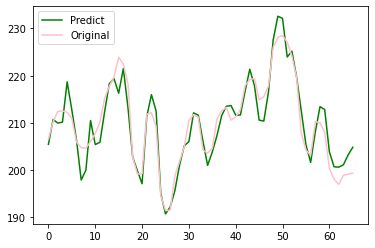

Running time: 528 seconds


In [50]:
#convlstm多变量多步 加入SED
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X1 = dataset[:,1]#Y
X1_scaler= (X1-numpy.min(X1))/(numpy.max(X1)-numpy.min(X1))
X1_scaler = X1_scaler.reshape(-1)

X2 = dataset[:,2]
X2_scaler= (X2-numpy.min(X2))/(numpy.max(X2)-numpy.min(X2))
X2_scaler = X2_scaler.reshape(-1)

X3 = dataset[:,3]
X3_scaler= (X3-numpy.min(X3))/(numpy.max(X3)-numpy.min(X3))
X3_scaler = X3_scaler.reshape(-1)

X4 = dataset[:,4]
X4_scaler= (X4-numpy.min(X4))/(numpy.max(X4)-numpy.min(X4))
X4_scaler = X4_scaler.reshape(-1)

X5 = dataset[:,5]
X5_scaler= (X5-numpy.min(X5))/(numpy.max(X5)-numpy.min(X5))
X5_scaler = X5_scaler.reshape(-1)

Y = dataset[:,0]
Y_scaler= (Y-numpy.min(Y))/(numpy.max(Y)-numpy.min(Y))
Y_scaler = Y_scaler.reshape(-1)



XX = numpy.zeros([324,3,3])
XX[:,0,0] = X1_scaler
XX[:,0,1] = Y_scaler
XX[:,0,2] = X2_scaler
XX[:,1,0] = Y_scaler
XX[:,1,1] = X3_scaler
XX[:,1,2] = Y_scaler
XX[:,2,0] = X4_scaler
XX[:,2,1] = Y_scaler
XX[:,2,2] = X5_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,3,3, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 3,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=48, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 3,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=24, kernel_size=(2, 2),activation='relu',
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 1),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    testPre1 = testPredict[:,1,0,:]
    testPre1 = testPre1.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    testBDX_re = testPre1*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    testBDX_re = testBDX_re.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    testPre_re=QSX + testBDX_re
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre_re[i])
        error1.append(abs((testY_ori[i] - testPre_re[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre_re[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre_re[i]*testPre_re[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=numpy.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre_re[i])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre_re=testPre_re.reshape(-1)
    testPre_re=pandas.DataFrame(testPre_re)
    testPre_re.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre_re,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre_re)



end = time.time()
print('Running time: %d seconds'%(end - start))